In [3]:
import pandas as pd

# Data reference

In [20]:
train_df = pd.read_csv("D:Dataset/dataset/hubmap-organ-segmentation/data_reference/train_fix_to256.csv")
train_df

,id,origin_id,organ,mask_img_path,train_img_path
0,10044_1_0,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
1,10044_4_0,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
2,10044_4_1,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
3,10044_4_2,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
4,10044_4_3,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
...,...,...,...,...,...
10525,9904_16_11,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10526,9904_16_12,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10527,9904_16_13,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10528,9904_16_14,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...


In [24]:
tmp = train_df["mask_img_path"].values[0]

(256, 256, 3)


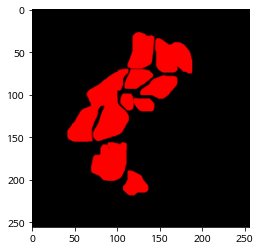

In [27]:
import matplotlib.pyplot as plt
tmp_img = plt.imread(tmp)
print(tmp_img.shape)
plt.imshow(tmp_img)

# Dataset

In [8]:
import tensorflow as tf

In [ ]:
train_img = tf.io.read_file(train_img_path)

In [121]:
def process_path(train_img_path, masked_img_path):  # image, label
    train_img = Image.open(train_img_path)
    mask_img = Image.open(train_img_path)
    train_img = tf.io.decode_png(train_img, channels=3)
    mask_img = tf.io.decode_png(mask_img, channels=3)
    
    mask_img = tf.expand_dims(mask_img[:,:,0],2)
    train_img = train_img /255
    return train_img.numpy(), mask_img.numpy


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=len(train_X))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTO)
    return ds

def configure_for_performance_test(ds):
    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTO)
    return ds

In [31]:
def valid_augment5(image, mask):
    return image, mask

def train_augment5b(image, mask):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

In [30]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

In [35]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [36]:
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

In [72]:
train_df[]

,id,origin_id,organ,mask_img_path,train_img_path
0,10044_1_0,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
1,10044_4_0,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
2,10044_4_1,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
3,10044_4_2,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
4,10044_4_3,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
...,...,...,...,...,...
10525,9904_16_11,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10526,9904_16_12,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10527,9904_16_13,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...
10528,9904_16_14,9904,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/ma...,D:Dataset/dataset/hubmap-organ-segmentation/tr...


In [85]:
from sklearn.model_selection import train_test_split as tts
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [118]:
X = train_df[train_df["organ"] == "prostate"].reset_index(drop=True)
train_X, valid_X = tts(X, test_size=0.15, shuffle=True, random_state=2021)
train_ds = tf.data.Dataset.from_tensor_slices((train_X["train_img_path"].values, train_X["mask_img_path"].values))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_X["train_img_path"].values, valid_X["mask_img_path"].values))

In [122]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTO)
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTO)

AttributeError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_13744\877989127.py", line 10, in process_path  *
        return train_img.numpy, mask_img.numpy

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [116]:
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance_test(valid_ds)

In [111]:
import numpy as np
import cv2

In [112]:
train_ds = train_ds.map(train_augment5b, num_parallel_calls=AUTO)

NotImplementedError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_13744\2948370501.py", line 5, in train_augment5b  *
        image, mask = do_random_flip(image, mask)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_13744\3437711948.py", line 12, in do_random_flip  *
        image = np.ascontiguousarray(image)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [91]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=4

In [92]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTO)
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTO)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance_test(valid_ds)

train_ds = train_ds.map(train_augment5b, num_parallel_calls=AUTOTUNE)

model = Unet('efficientnetb2',input_shape=(256, 256, 3), classes=1, activation='sigmoid', encoder_weights=None)
model.compile(loss=bce_dice_loss, optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),metrics=['acc', dice_coef])

TypeError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_13744\2004627773.py", line 2, in process_path  *
        train_img = tf.io.read_file(train_img_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.
